In [ ]:
#default_exp meta.distributions

In [ ]:
#TODO: Include GMM from skleaern for multimodal normal
#TODO: Include percentile method for ECDF methods (sklearn.preprocessing.QuantileTransformer)

# Meta Distributions

> Extension of SciPy rv_continuous Class, containing some useful methods for Maximum Likelihood Estimation and other distribution methods.

## Helper Functions

In [80]:
#export
from sklearn.preprocessing import QuantileTransformer
import scipy.stats as stats
import numpy as np
import tqdm


def ctqdm(iterable, verbose = False, notebook = False,**tqdm_kwargs):
    '''
    progress bar handler (custom tqdm)
    '''
    if not verbose:
        return iterable
    else:
        if notebook:
            return tqdm.notebook(iterable,**tqdm_kwargs)
        else:
            return tqdm.tqdm(iterable,**tqdm_kwargs)




## RandomVariable Class - 

In [58]:
        
class RandomVariable():
    '''
    A container for distribution objects
    '''
    
    def __init__(self, data, verbose = False):        
        self.samples = data
        self._fitted_dists = {}
        self.verbose = False
        return
    
    
    def __getitem__(self, item):
        if item == 'best':
            item = self._best_fit_alias
        return self._fitted_dists[item][0]
    
    def __repr__(self):
        return repr(self.samples)
    
    def fit_best(self, data, candidates):
        #fit all and make alias for best fit
        self._fit_all(data, candidates)
        dists_aliases = list(self._fitted_dists)
        dists_arr = np.array([i[1] for i in self._fitted_dists.values()])
        best_fit_idx = np.argmax(dists_arr)
        self._best_fit_alias = dists_aliases[best_fit_idx]
        return self
    
    def _fit_all(self, data, candidates):        
        #TODO: check for multiplicity in candidates aliases
        for candidate in ctqdm(candidates, verbose = self.verbose):
            self.fit_dist(data, candidate)            
        return self
    
    def fit_dist(self, data, dist):      
        '''
        fits a specified distribution through scipy.stats.rv_continuous.fit method
        '''
        alias, dist_name = self._handle_dist_names(dist)
        alias, dist_class = self._get_dist_from_name(alias, dist_name)
        if alias.lower() == 'best':
            raise ValueError('"best" cannot be an alias for a distribution. its internally assgined to the best fit dist')
        params = dist_class.fit(data)
        log_likelihood = self._get_log_likelihood(data, dist_class, params)
        self._fitted_dists = {**self._fitted_dists, **{alias:(dist_class(*params),log_likelihood)}}        
        return self
    
    def _get_log_likelihood(self, data, dist, params):        
        return np.log(np.product(dist.pdf(data,*params)))
    
    def _get_dist_from_name(self, alias, dist_name):
        '''
        handles dist_names. if str tries to get an attribute from scipy.stats accordingly
        that is also instance of scipy.stats.rv_continuous
        '''
        if isinstance(dist_name,str):        
            if isinstance(getattr(stats,dist_name), stats.rv_continuous):
                alias = dist_name
                return (alias, getattr(stats,dist_name))
            else:
                raise ValueError(f'dist must be a valid scipy.stats.rv_continuous instance, not {getattr(stats,dist_name).__class__}')

        elif isinstance(dist_name, stats.rv_continuous):
            return (alias, dist_name)
        else:
            raise ValueError(f'dist must be a valid scipy.stats.rv_continuous instance or str, not {dist_name.__class__}')

    def quantile(self, X)
    def inverse_qunatile(self, X)
    def _fit_quantile_transformer(self, data):
        
    
    def _handle_dist_names(self, candidate_value):
        '''
        checks the inputs in elements of "candidates"
        returns a named tuple
        '''
        if isinstance(candidate_value, str):
            return candidate_value, candidate_value

        elif isinstance(candidate_value, tuple):

            if not len(candidate_value) == 2:
                raise ValueError(f'candidate named tuple must be of size 2, "{candidate_value}" has size {len(candidate_value)}')

            if not isinstance(candidate_value[0], str):
                raise ValueError(f'a candidate must be a str or named tuple (alias[str],<rv_continuous intance>), alias is of type {candidate_value[0].__class__}')

            else:
                return candidate_value     

In [59]:
#check for np.vectorize for vectorized methods
class RVArray():
    '''
    An array that contains rv scipy functions and performs their methods in a vectorwise fashion
    '''
    def __init__(self, data):
        ''' the constructor recieves a list of RandomVariable items'''
        self.data = data
        return
    def __getitem__(self, *idxs):
        

A RandomVariable Class facilitates the process of fitting multiple parametric distributions avalible in https://docs.scipy.org/doc/scipy/reference/stats.html from a data sample, for example:

Dist args:
(1, 0, 2)
MLE fitted dist args:
(1.3595358810627385, 0.7314107789905318, 1.0109655706609542)


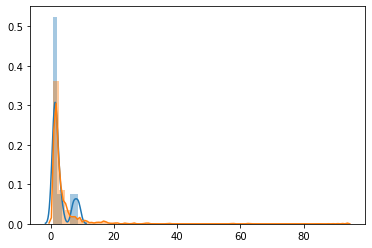

In [107]:
import seaborn as sns
dist_args = (1,0,2)

data = stats.lognorm.rvs(dist_args[0], loc = dist_args[1], scale = dist_args[2], size = 10)
rv = RandomVariable(data)
rv.fit_best(data, candidates = ['norm','halfnorm','lognorm'])

mle_samples = rv['best'].rvs(1000)
#plot distributions
print('Dist args:')
print(dist_args)
print('MLE fitted dist args:')
print(rv['best'].args)

sns.distplot(data)
sns.distplot(mle_samples)
